In [1]:
import sys
import os

sys.path.append('..')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [7]:
# Define paths to the data directories

# Get the project root directory
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/"

# Declare data directories
train_data_dir = os.path.join(ROOT_DIR, 'raw_data/training_set')
test_data_dir = os.path.join(ROOT_DIR, 'raw_data/test_set')

In [8]:
# Image dimensions
img_width, img_height = 224, 224

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling for test set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of image data with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

# Generate batches of image data for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

Found 311 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


## Model Definition and Fine-Tuning

In [9]:
def create_fine_tuned_model(base_model):
    """
    Creates a fine-tuned model from a pre-trained base model.
    """
    # Freeze all convolutional layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output of the convolutional base
    x = base_model.output
    x = Flatten()(x)

    # Add fully connected layers for classification
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x) # Binary classification

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
# Create instances of pre-trained models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [11]:
# Create fine-tuned models
vgg_model_ft = create_fine_tuned_model(vgg_model)
resnet_model_ft = create_fine_tuned_model(resnet_model)
inception_model_ft = create_fine_tuned_model(inception_model)

## Model Training

In [12]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the models
history_vgg = vgg_model_ft.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=test_generator,
    callbacks=[early_stopping]
)

history_resnet = resnet_model_ft.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

history_inception = inception_model_ft.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
10/10 [==============================] - 350s 36s/step - loss: 1.3047 - accuracy: 0.6045 - val_loss: 0.6246 - val_accuracy: 0.6322
Epoch 2/10
10/10 [==============================] - 284s 29s/step - loss: 0.6746 - accuracy: 0.6592 - val_loss: 0.6595 - val_accuracy: 0.6034
Epoch 3/10
10/10 [==============================] - 321s 33s/step - loss: 0.5541 - accuracy: 0.7170 - val_loss: 0.6645 - val_accuracy: 0.5575
Epoch 4/10
10/10 [==============================] - 278s 29s/step - loss: 0.4145 - accuracy: 0.8167 - val_loss: 0.5365 - val_accuracy: 0.7299
Epoch 5/10
10/10 [==============================] - 322s 34s/step - loss: 0.3904 - accuracy: 0.8103 - val_loss: 0.5246 - val_accuracy: 0.7759
Epoch 6/10
10/10 [==============================] - 322s 34s/step - loss: 0.3467 - accuracy: 0.8489 - val_loss: 0.5133 - val_accuracy: 0.7701
Epoch 7/10
10/10 [==============================] - 277s 29s/step - loss: 0.3203 - accuracy: 0.8810 - val_loss: 0.5168 - val_accuracy: 0.7644
Epoch 

## Model Evaluation

In [13]:
# Make predictions on the test set
vgg_preds = vgg_model_ft.predict(test_generator)
resnet_preds = resnet_model_ft.predict(test_generator)
inception_preds = inception_model_ft.predict(test_generator)

6/6 [==============================] - 22s 3s/step


In [14]:
# Convert probabilities to class labels
vgg_preds_classes = (vgg_preds > 0.5).astype(int)
resnet_preds_classes = (resnet_preds > 0.5).astype(int)
inception_preds_classes = (inception_preds > 0.5).astype(int)

# Get true labels from the generator
true_labels = test_generator.classes

## Performance Metrics

In [15]:
# Create a dictionary to store the results
results = {}

for model_name, predictions in [('VGG16', vgg_preds_classes),
                                 ('ResNet50', resnet_preds_classes),
                                 ('InceptionV3', inception_preds_classes)]:

    results[model_name] = {
        'Accuracy': accuracy_score(true_labels, predictions),
        'Loss': history_vgg.history['val_loss'][-1] if model_name == 'VGG16' else \
                history_resnet.history['val_loss'][-1] if model_name == 'ResNet50' else \
                history_inception.history['val_loss'][-1],
        'Precision': precision_score(true_labels, predictions),
        'Recall': recall_score(true_labels, predictions),
        'F1 Score': f1_score(true_labels, predictions),
        'AUC': roc_auc_score(true_labels, predictions)
    }

## Results Visualization

Model Performance:
Model           Accuracy   Loss       Precision  Recall     F1 Score   AUC       
VGG16           0.6609     0.7347     0.6766     0.9576     0.7930     0.4967    
ResNet50        0.6782     0.6837     0.6782     1.0000     0.8082     0.5000    
InceptionV3     0.4425     2.4639     0.6235     0.4492     0.5222     0.4389    


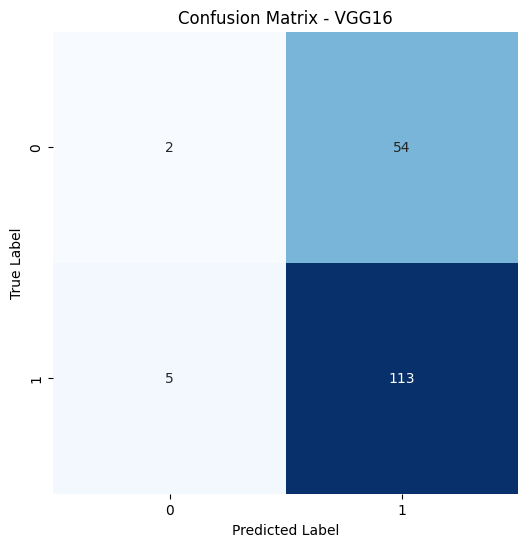

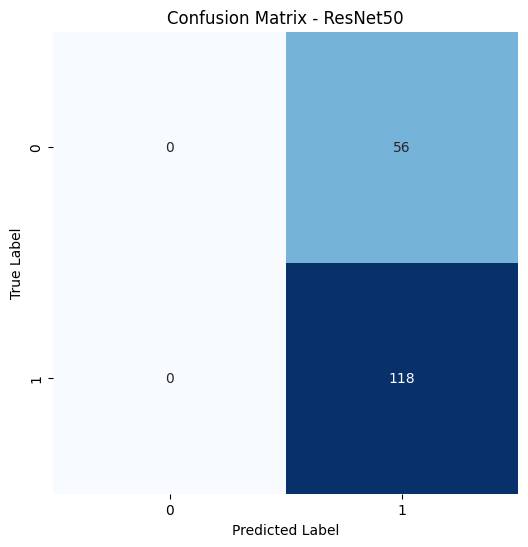

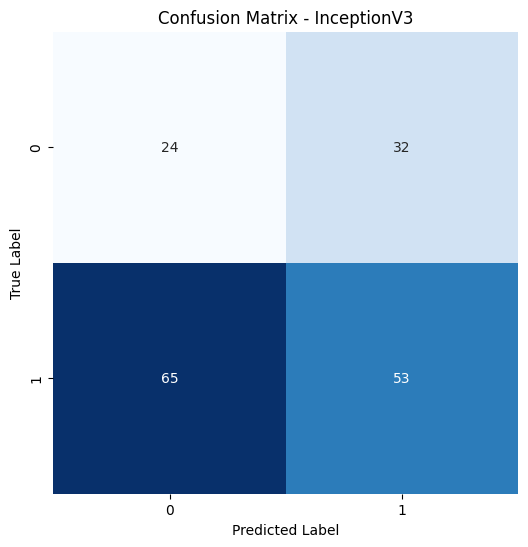

In [16]:
# Print the results table
print("Model Performance:")
print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Model', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1 Score', 'AUC'))
for model_name, metrics in results.items():
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(model_name, metrics['Accuracy'], metrics['Loss'], metrics['Precision'], metrics['Recall'], metrics['F1 Score'], metrics['AUC']))

# Plot the confusion matrices
for model_name, predictions in [('VGG16', vgg_preds_classes),
                                 ('ResNet50', resnet_preds_classes),
                                 ('InceptionV3', inception_preds_classes)]:
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()